In [5]:
# Multiclass Logistic Regression
# http://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html

from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [6]:
# Load Minist
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.MNIST(train=False, transform=transform)

In [7]:
# show shape
image, label = mnist_train[0]
print(image.shape, label)

(28, 28, 1) 5.0


In [8]:
# define variables
# http://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html#Record-the-data-and-label-shapes
num_inputs = 784
num_outputs = 10
num_examples = 60000



In [9]:

im = mx.nd.tile(image, (1,1,3))
print(im.shape)

(28, 28, 3)


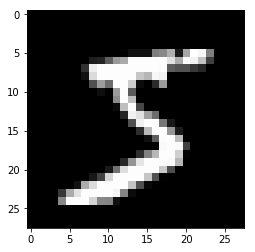

In [11]:
import matplotlib.pyplot as plt
plt.imshow(im.asnumpy())
plt.show()

In [12]:
# Load iterator
batch_size = 64
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

In [13]:
# Model params
# http://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html#Allocate-model-parameters
W = nd.random_normal(shape=(num_inputs, num_outputs),ctx=model_ctx)
b = nd.random_normal(shape=num_outputs,ctx=model_ctx)

params = [W, b]

for param in params:
    param.attach_grad()

In [14]:

def softmax(y_linear): # y_linear shape (64, 10)
    exp = nd.exp(y_linear - nd.max(y_linear, axis=1).reshape((-1,1)))
    norms = nd.sum(exp, axis=1).reshape((-1,1))
    return exp / norms

In [15]:
sample_y_linear = nd.random_normal(shape=(2,10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)


[[ 0.38854712  0.15868284  0.09794893  0.01202093  0.01595045  0.04553349
   0.14224595  0.0314311   0.04231628  0.06532289]
 [ 0.08514825  0.43826103  0.02771222  0.08836042  0.17408127  0.05132056
   0.02093019  0.06935012  0.03025253  0.01458343]]
<NDArray 2x10 @cpu(0)>


In [16]:
print(nd.sum(sample_yhat, axis=1))
print(nd.sum(sample_yhat, axis=1).shape)


[ 1.  1.]
<NDArray 2 @cpu(0)>
(2,)


In [27]:
# Define the model
net_count = 0
def net(X):
    global net_count
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    if net_count < 1:
        print(X.shape)
        print(W.shape)
        print(b.shape)
        print(y_linear.shape)
        print(yhat.shape)
#         print(X)
#         print(W)
        print(b)
        print(y_linear[0])
        print(yhat[0])
        print(nd.sum(yhat[0],axis=0))
    net_count +=1
    return yhat

In [28]:
# loss function (cross entropy)
# http://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html#The-cross-entropy-loss-function

def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat+1e-6))

In [29]:
# optimizer
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [30]:
# Evaluation Loop
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [31]:
evaluate_accuracy(test_data, net)

(64, 784)
(784, 10)
(10,)
(64, 10)
(64, 10)

[ 0.70224744 -0.84411263 -0.55587363  0.09676385 -2.33292747  2.25721431
  0.03539884 -0.49671832  0.27115455 -1.40046799]
<NDArray 10 @cpu(0)>

[  0.68086439   7.85433865  12.9561224   -8.33979416   1.55413008
  -3.56905437  13.49463463  -6.14846897  -5.2002573  -12.28996468]
<NDArray 10 @cpu(0)>

[  1.71563499e-06   2.23782030e-03   3.67706865e-01   2.07397113e-10
   4.10846496e-06   2.44742271e-08   6.30049467e-01   1.85559301e-09
   4.78945150e-09   3.99268856e-12]
<NDArray 10 @cpu(0)>

[ 1.]
<NDArray 1 @cpu(0)>


0.1167

In [33]:
# Training Loop
epochs = 5
learning_rate = .005
inner_loop_c = 0
for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
#         if inner_loop_c < 1:
#             print(label)
#             print(label_one_hot)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
            if inner_loop_c < 1:
                print(loss)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()
        inner_loop_c += 1


    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))


[ 54.31549835]
<NDArray 1 @cpu(0)>
Epoch 0. Loss: 0.616875357747, Train_acc 0.881, Test_acc 0.8833
Epoch 1. Loss: 0.518192875775, Train_acc 0.890483, Test_acc 0.8873
Epoch 2. Loss: 0.467312068756, Train_acc 0.896433, Test_acc 0.8967
Epoch 3. Loss: 0.434628704079, Train_acc 0.9006, Test_acc 0.8956
Epoch 4. Loss: 0.410836784077, Train_acc 0.903817, Test_acc 0.9014


(10, 28, 28, 1)


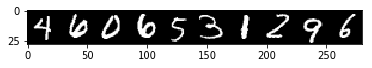

model predictions are: 
[ 4.  6.  0.  6.  5.  3.  1.  2.  9.  6.]
<NDArray 10 @cpu(0)>


In [32]:
# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break